# Import relevant libraries

In [3]:
import matplotlib.pyplot as plt   
import seaborn as sns; sns.set()  
import numpy as np  
import pandas as pd 
import scipy.cluster.hierarchy as shc  
from sklearn.cluster import KMeans 
from sklearn.cluster import AgglomerativeClustering 
from datetime import datetime, timedelta

## Reading function

In [4]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["time"] = pd.to_datetime(trip_data["time"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])
    return trip_data

In [5]:
dataBr = read_data("Bremen")
dataDu = read_data("Duesseldorf")

In [6]:
city1 = "Bremen"
city2 = "Duesseldorf"
start_date = "2019-02-01 00:00:00"
end_date = "2019-02-28 23:59:00"
startDate = datetime.fromisoformat(start_date)
endDate = datetime.fromisoformat(end_date)

In [7]:
dataBr.head(10)

,Unnamed: 0,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,...,fleetsize_weekly,fleetsize_dayly,fleetsize_monthly,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain
0,0,2019-04-21,2021-01-21 17:34:00,20507,bremen,00:13:00,53.078923,8.884911,53.078711,8.899906,...,331,163,395,1.001900,0.216667,4.624155,2019-04-21 18:00:00,20.4,2.0,0.0
1,1,2019-05-23,2021-01-21 15:33:00,20507,bremen,00:07:00,53.078923,8.884911,53.078004,8.876828,...,310,172,373,0.549476,0.116667,4.709793,2019-05-23 16:00:00,20.7,2.4,0.0
2,2,2019-06-14,2021-01-21 22:30:00,20507,bremen,00:08:00,53.078923,8.884911,53.074731,8.876003,...,304,204,342,0.755886,0.133333,5.669146,2019-06-14 22:00:00,19.6,4.4,0.0
3,3,2019-06-16,2021-01-21 10:00:00,20507,bremen,02:02:00,53.074731,8.876003,53.078923,8.884911,...,304,184,342,0.755886,2.033333,0.371747,2019-06-16 10:00:00,21.6,3.0,0.0
4,4,2019-06-16,2021-01-21 12:55:00,20507,bremen,02:23:00,53.078923,8.884911,53.076236,8.891322,...,304,184,342,0.522213,2.383333,0.219110,2019-06-16 13:00:00,21.8,4.4,0.0
5,5,2019-06-28,2021-01-21 13:07:00,20507,bremen,00:49:00,53.078923,8.884911,53.073298,8.794316,...,284,166,342,6.084054,0.816667,7.449862,2019-06-28 13:00:00,21.5,3.2,0.0
6,6,2019-06-28,2021-01-21 15:01:00,20507,bremen,00:49:00,53.073529,8.794269,53.077716,8.897971,...,284,166,342,6.943062,0.816667,8.501708,2019-06-28 15:00:00,22.1,4.3,0.0
7,7,2019-02-24,2021-01-21 09:44:00,20508,bremen,00:22:00,53.158160,8.945250,53.127139,8.898528,...,267,116,338,4.648571,0.366667,12.677921,2019-02-24 10:00:00,6.6,1.2,0.0
8,8,2019-02-24,2021-01-21 13:20:00,20508,bremen,01:11:00,53.127139,8.898528,53.113707,9.077220,...,267,116,338,12.017662,1.183333,10.155771,2019-02-24 13:00:00,13.1,1.1,0.0
9,9,2019-02-24,2021-01-21 15:28:00,20508,bremen,01:32:00,53.113711,9.077380,53.081751,8.810349,...,267,116,338,18.179632,1.533333,11.856281,2019-02-24 15:00:00,14.2,1.2,0.0


In [8]:
# coordinates of city center as [lat, lng]
city1_center = [53.078893247451994, 8.8027747491885]
city2_center = [51.226815497281706, 6.773786392066722]

## Data for Clustering
### Bremen

In [9]:
# set time window for the given data

dat_time_framed_br = dataBr.loc[(dataBr["datetime_start"] > startDate) & (dataBr["datetime_start"] <= endDate)]
dat_time_framed_du = dataDu.loc[(dataDu["datetime_start"] > startDate) & (dataDu["datetime_start"] <= endDate)]

In [10]:
dat_time_framed_br

,Unnamed: 0,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,...,fleetsize_weekly,fleetsize_dayly,fleetsize_monthly,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain
7,7,2019-02-24,2021-01-21 09:44:00,20508,bremen,00:22:00,53.158160,8.945250,53.127139,8.898528,...,267,116,338,4.648571,0.366667,12.677921,2019-02-24 10:00:00,6.6,1.2,0.0
8,8,2019-02-24,2021-01-21 13:20:00,20508,bremen,01:11:00,53.127139,8.898528,53.113707,9.077220,...,267,116,338,12.017662,1.183333,10.155771,2019-02-24 13:00:00,13.1,1.1,0.0
9,9,2019-02-24,2021-01-21 15:28:00,20508,bremen,01:32:00,53.113711,9.077380,53.081751,8.810349,...,267,116,338,18.179632,1.533333,11.856281,2019-02-24 15:00:00,14.2,1.2,0.0
10,10,2019-02-25,2021-01-21 12:03:00,20508,bremen,00:05:00,53.081622,8.810291,53.076409,8.810433,...,287,123,338,0.579713,0.083333,6.956553,2019-02-25 12:00:00,12.9,1.8,0.0
11,11,2019-02-25,2021-01-21 12:29:00,20508,bremen,00:07:00,53.076344,8.810426,53.082311,8.799219,...,287,123,338,1.000290,0.116667,8.573916,2019-02-25 12:00:00,12.9,1.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57517,57517,2019-02-28,2021-01-21 13:24:00,20997,bremen,00:09:00,53.076722,8.803943,53.083324,8.786275,...,287,125,338,1.389882,0.150000,9.265883,2019-02-28 13:00:00,6.1,4.0,0.0
57518,57518,2019-02-28,2021-01-21 17:40:00,20997,bremen,00:09:00,53.099493,8.790572,53.098991,8.800228,...,287,125,338,0.647104,0.150000,4.314026,2019-02-28 18:00:00,4.4,0.8,0.0
57519,57519,2019-02-28,2021-01-21 20:23:00,20997,bremen,00:25:00,53.098971,8.799805,53.081680,8.864563,...,287,125,338,4.732622,0.416667,11.358294,2019-02-28 20:00:00,4.9,0.8,0.0
57731,57731,2019-02-21,2021-01-21 06:32:00,20998,bremen,00:13:00,53.083167,8.811472,53.089444,8.777833,...,267,119,338,2.352508,0.216667,10.857728,2019-02-21 07:00:00,5.6,4.6,0.0


In [11]:
dat_time_framed_br.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6739 entries, 7 to 57732
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Unnamed: 0           6739 non-null   int64          
 1   day                  6739 non-null   datetime64[ns] 
 2   time                 6739 non-null   datetime64[ns] 
 3   b_number             6739 non-null   int64          
 4   city                 6739 non-null   object         
 5   trip_duration        6739 non-null   timedelta64[ns]
 6   orig_lat             6739 non-null   float64        
 7   orig_lng             6739 non-null   float64        
 8   dest_lat             6739 non-null   float64        
 9   dest_lng             6739 non-null   float64        
 10  datetime_start       6739 non-null   datetime64[ns] 
 11  datetime_end         6739 non-null   datetime64[ns] 
 12  weekday              6739 non-null   int64          
 13  month            

## Create some plots to get an intuition of what clusters could be found

#### Bremen

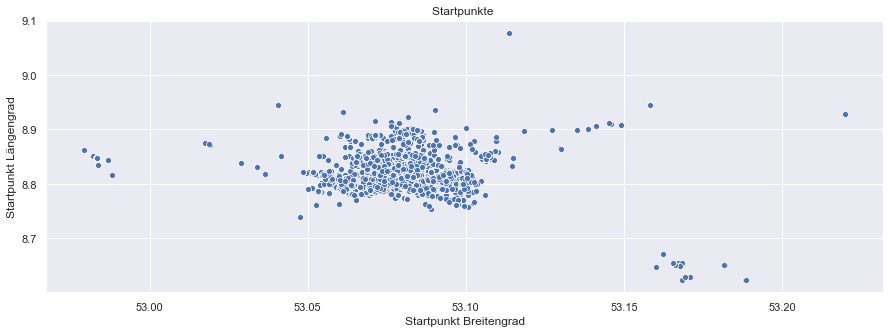

In [12]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

g = sns.scatterplot(ax = ax, data=dat_time_framed_br, x="orig_lat", y="orig_lng", ci=None);  
ax.set_title('Startpunkte ')  
ax.set_xlabel('Startpunkt Breitengrad');
ax.set_ylabel('Startpunkt Längengrad');

# add a marker for the city center

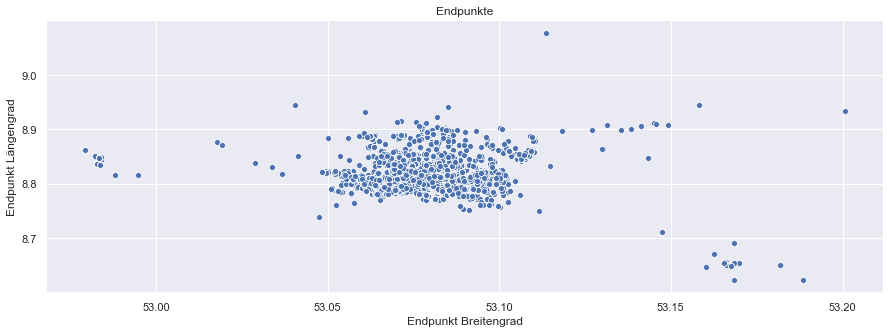

In [13]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

g = sns.scatterplot(ax = ax, data=dat_time_framed_br, x="dest_lat", y="dest_lng", ci=None);  
ax.set_title('Endpunkte')  
ax.set_xlabel('Endpunkt Breitengrad');
ax.set_ylabel('Endpunkt Längengrad');

# add a marker for the city center

(0.0, 23.0)

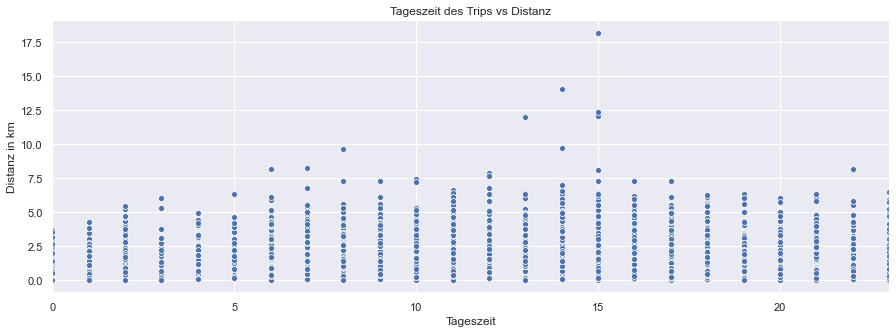

In [14]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

g = sns.scatterplot(ax = ax, data=dat_time_framed_br, x=dat_time_framed_br["datetime_start"].dt.hour, y="distance", ci=None);  
ax.set_title('Tageszeit des Trips vs Distanz')  
ax.set_xlabel('Tageszeit');
ax.set_ylabel('Distanz in km');
ax.set_xlim(dat_time_framed_br['datetime_start'].dt.hour.min(), dat_time_framed_br['datetime_start'].dt.hour.max())

#### Düsseldorf

## Clustering 

### Prepare Data

In [22]:
# Merkmale/Variablen Feuchtigk. und Temp. separat speichern
#X = dat_time_framed[["datetime_start","distance"]]
X = dat_time_framed_br;
X["datetime_start"] = pd.to_numeric(X["datetime_start"])
X["datetime_end"] = pd.to_numeric(X["datetime_start"])
X["day"] = pd.to_numeric(X["day"])
X["time"] = pd.to_numeric(X["time"])
X["trip_duration"] = pd.to_numeric(X["trip_duration"])


<ipython-input-22-93dbf1d8eb7b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["datetime_start"] = pd.to_numeric(X["datetime_start"])
<ipython-input-22-93dbf1d8eb7b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["datetime_end"] = pd.to_numeric(X["datetime_start"])
<ipython-input-22-93dbf1d8eb7b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6739 entries, 7 to 57732
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           6739 non-null   int64  
 1   day                  6739 non-null   int64  
 2   time                 6739 non-null   int64  
 3   b_number             6739 non-null   int64  
 4   city                 6739 non-null   object 
 5   trip_duration        6739 non-null   int64  
 6   orig_lat             6739 non-null   float64
 7   orig_lng             6739 non-null   float64
 8   dest_lat             6739 non-null   float64
 9   dest_lng             6739 non-null   float64
 10  datetime_start       6739 non-null   int64  
 11  datetime_end         6739 non-null   int64  
 12  weekday              6739 non-null   int64  
 13  month                6739 non-null   int64  
 14  hour                 6739 non-null   int64  
 15  week                 6739 non-null   

C:\Users\andre\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


                  0            1
count   6739.000000  6739.000000
mean   32503.210565     2.128654
std    14475.049042     1.347990
min        7.000000     0.000000
25%    20658.500000     1.000000
50%    34060.000000     2.000000
75%    45242.500000     3.000000
max    57732.000000     4.000000


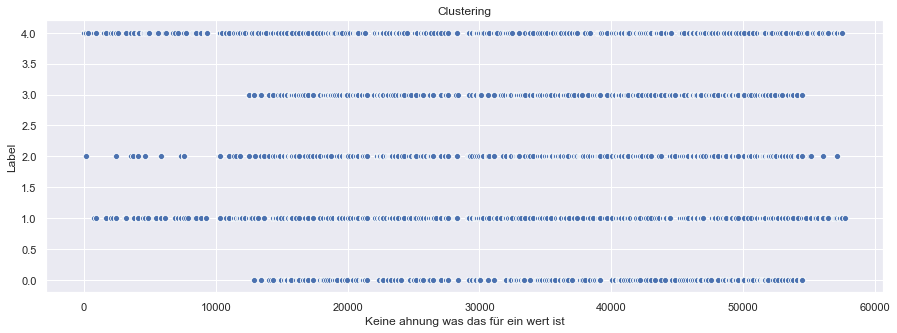

In [24]:
X.info()
X.drop("city", axis=1, inplace=True)
X.drop("rounded_time_hourly", axis=1, inplace=True)
# convert all non numeric values
for column in X:
    print(X[column].dtype)
    if type(X[column]) in ("datetime64[ns]", "timedelta64[ns]"):
        print(column)
        X[column] = X[column].total_seconds()
    elif type(X[column]) not in ("int64", "float64"):
        pd.to_numeric(X[column])

X.info()
        
# Convert DataFrame to matrix
mat = X.values




#Anzahl der Zentren festlegen
kmeans = KMeans(n_clusters=5) 

# Vorhersage mittels K-Means-Verfahren
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Get cluster assignment labels
labels = kmeans.labels_
# Format results as a DataFrame
results = pd.DataFrame([X.index,labels]).T


print(results.describe())


xFirstColumn = results.iloc[:, 0]
xSecondColumn = results.iloc[:, 1]

fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))


g = sns.scatterplot(ax = ax, x=xFirstColumn, y=xSecondColumn, ci=None);  
ax.set_title('Clustering')  
ax.set_xlabel('Keine ahnung was das für ein wert ist');
ax.set_ylabel('Label');
#max.set_xlim(dat_time_framed['datetime_start'].dt.hour.min(), dat_time_framed['datetime_start'].dt.hour.max())

In [32]:
Z = dat_time_framed_br[["distance","datetime_start"]]
Z["datetime_start"] = Z["datetime_start"].dt.hour
Z.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6739 entries, 7 to 57732
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distance        6739 non-null   float64
 1   datetime_start  6739 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 477.9 KB


<ipython-input-32-45ea96685ce4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z["datetime_start"] = Z["datetime_start"].dt.hour


In [38]:
km = KMeans(n_clusters=3)
km_z = km.fit_predict(Z)
km_z

array([1, 0, 0, ..., 2, 1, 2])

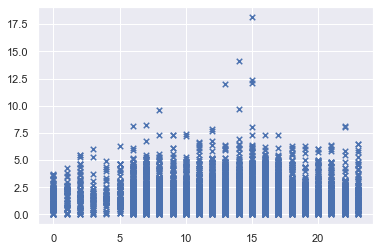

In [39]:
plt.scatter(
   Z["datetime_start"], Z["distance"],
   c='b', marker='x', s=30
)
plt.show()

In [54]:
Z[km_z==0]

,distance,datetime_start
8,12.017662,13
9,18.179632,15
10,0.579713,12
11,1.000290,12
172,0.515087,10
...,...,...
57325,0.213085,10
57503,4.170343,15
57510,5.645296,14
57512,0.140911,15


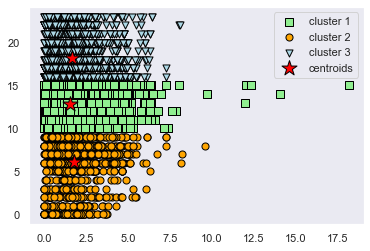

In [57]:
plt.scatter(
    Z[km_z == 0]["distance"], Z[km_z == 0]["datetime_start"],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    Z[km_z == 1]["distance"], Z[km_z == 1]["datetime_start"],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    Z[km_z == 2]["distance"], Z[km_z == 2]["datetime_start"],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

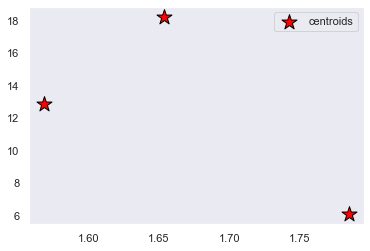

In [31]:

Y = dat_time_framed_du[["trip_duration","rain"]]
Y["trip_duration"] = Y["trip_duration"].apply(lambda x: x.total_seconds())

kmeans_du = KMeans(n_clusters=4) 

# Vorhersage mittels K-Means-Verfahren
kmeans_du.fit(Y)
kmeans_du.predict(Y)

<ipython-input-31-759a13ccc866>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y["trip_duration"] = Y["trip_duration"].apply(lambda x: x.total_seconds())


array([2, 2, 0, 1, 1, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 3, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1,
       2, 2, 0, 2, 3, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 3, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 0, 3, 2, 0, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,